In [1]:
"""
Learning to optimize parametric Quadratic Programming (pQP)
problems using Neuromancer.

Problem formulation pQP:
    minimize     x^2 + y^2
    subject to
               -x - y + p1 <= 0,
               x + y - p1 - 5 <= 0,
               x - y + p2 - 5 <= 0,
               -x + y - p2 <= 0
"""



'\nLearning to optimize parametric Quadratic Programming (pQP)\nproblems using Neuromancer.\n\nProblem formulation pQP:\n    minimize     x^2 + y^2\n    subject to\n               -x - y + p1 <= 0,\n               x + y - p1 - 5 <= 0,\n               x - y + p2 - 5 <= 0,\n               -x + y - p2 <= 0\n'

In [2]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node


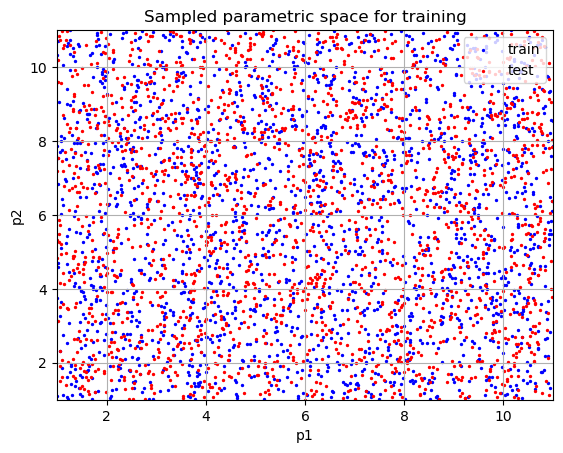

In [3]:

"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
nsim = 2000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 1.0, 11.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                    "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=100, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)


In [4]:

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# define symbolic solution map with concatenated features (problem parameters)
xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['xi'], ['x'], name='map')
# trainable components of the problem solution
components = [features, sol_map]
"""
# # #  mpQP objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')
# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]
# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
g2 = x + y - p1 - 5
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
g3 = x - y + p2 - 5
con_3 = Q_con*(g3 <= 0)
con_3.name = 'c3'
g4 = -x + y - p2
con_4 = Q_con*(g4 <= 0)
con_4.name = 'c4'
constraints = [con_1, con_2, con_3, con_4]
"""
# # #  pQP problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
nm_problem = Problem(components, loss)


In [5]:

"""
# # #  pQP problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(nm_problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    nm_problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=200,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()



epoch: 0  train_loss: 499.3981018066406
epoch: 1  train_loss: 104.82307434082031
epoch: 2  train_loss: 53.215354919433594
epoch: 3  train_loss: 36.80646896362305
epoch: 4  train_loss: 31.209644317626953
epoch: 5  train_loss: 31.178592681884766
epoch: 6  train_loss: 32.67618179321289
epoch: 7  train_loss: 32.79008865356445
epoch: 8  train_loss: 29.859180450439453
epoch: 9  train_loss: 30.917348861694336
epoch: 10  train_loss: 33.20261764526367
epoch: 11  train_loss: 30.912572860717773
epoch: 12  train_loss: 29.789688110351562
epoch: 13  train_loss: 30.847763061523438
epoch: 14  train_loss: 31.2630615234375
epoch: 15  train_loss: 33.90863800048828
epoch: 16  train_loss: 30.469806671142578
epoch: 17  train_loss: 32.60869598388672
epoch: 18  train_loss: 28.806875228881836
epoch: 19  train_loss: 28.876506805419922
epoch: 20  train_loss: 30.898757934570312
epoch: 21  train_loss: 28.580575942993164
epoch: 22  train_loss: 35.081932067871094
epoch: 23  train_loss: 30.5918025970459
epoch: 24  tr

In [25]:

'''
#######################################
#######################################

Add on an ADMM Correction Layer 

Using heuristic metric Choice

#######################################
########################################
'''

import ADMM as am
from importlib import reload
reload(am)
'''
# DEFINE THE OBJECTIVE
'''
def f_obj(x,parms):
    return torch.pow( x[0] ,2) + torch.pow( x[1], 2)
'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,parms):
    c_1 = -x[0] - x[1] + parms[0]
    c_2 = x[0] + x[1] - parms[0] - 5 
    c_3 = x[0] - x[1] + parms[1] - 5 
    c_4 = -x[0] + x[1] - parms[1]
    return torch.stack((c_1,c_2,c_3,c_4))
num_steps = 5 # number of DR iterations to take
x_dim = 2 # dimension of primal variable
n_ineq = 4 #number of inequality constraints
parm_dim = 2 #number of problem parameters




#metric scaling parameters
initial_lb_P = 1e-6
initial_ub_P = 1e6
lb_P = 1.0/10.0
ub_P = 10.0
scl_lb_P = 0.05
scl_ub_P = 1.0

met = am.ParametricDiagonal(x_dim+n_ineq,parm_dim,ub_P,lb_P,scl_ub_P,scl_lb_P )


solver = am.ADMMSolver(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    x_dim = x_dim, 
    n_ineq = n_ineq, 
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    Metric = met,
    )



# REMAP THROUGH ADMM CORRECTION
sol_map = Node(func, ['xi'], ['x_predicted'], name='map')
ADMM_correction = Node(solver,['x_predicted','xi'],['x','r_gap','s_gap','x_history'])
components = [features, sol_map, ADMM_correction]
r_gap = variable("r_gap")
s_gap = variable("s_gap")
#f_cnv = (r_gap)**2 + (s_gap)**2
f_cnv = (r_gap)**2
#f_cnv = (s_gap)**2
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []

# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)



In [26]:

'''
#######################################
#######################################

Train ADMM correction layer

#######################################
########################################
'''
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-2)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=100,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)
# Train solution map
best_model = trainer.train()


epoch: 0  train_loss: 634201.6875
epoch: 1  train_loss: 18486.103515625
epoch: 2  train_loss: 18480.376953125
epoch: 3  train_loss: 18480.1875
epoch: 4  train_loss: 18480.115234375
epoch: 5  train_loss: 18480.1875
epoch: 6  train_loss: 18480.2734375
epoch: 7  train_loss: 18480.2109375
epoch: 8  train_loss: 18480.125
epoch: 9  train_loss: 18480.09375
epoch: 10  train_loss: 18480.150390625
epoch: 11  train_loss: 18480.23828125
epoch: 12  train_loss: 18480.201171875
epoch: 13  train_loss: 18480.21875
epoch: 14  train_loss: 18480.19921875
epoch: 15  train_loss: 18480.25
epoch: 16  train_loss: 18480.31640625
epoch: 17  train_loss: 18480.21484375
epoch: 18  train_loss: 18480.09765625
epoch: 19  train_loss: 18480.23046875
epoch: 20  train_loss: 18480.23828125
Interrupted training loop.


In [27]:
solver.num_steps = 10

/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_80007/1758468276.py:57: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_80007/1758468276.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg2.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_80007/1758468276.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg3.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_80007/1758468276.py:63: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg4.collections,


primal solution x=[1.], y=[1.]
parameter p=(2.0, 2.0)
primal solution Neuromancer x1=1.5416996479034424, x2=0.45824384689331055
primal solution x=[1.5], y=[1.5]
parameter p=(3.0, 3.0)
primal solution Neuromancer x1=1.860717535018921, x2=1.1392635107040405
primal solution x=[2.], y=[2.]
parameter p=(4.0, 4.0)
primal solution Neuromancer x1=2.1766276359558105, x2=1.8233954906463623
primal solution x=[2.5], y=[2.5]
parameter p=(5.0, 5.0)
primal solution Neuromancer x1=2.474472999572754, x2=2.5255448818206787
primal solution x=[2.5], y=[3.5]
parameter p=(6.0, 6.0)
primal solution Neuromancer x1=2.500086784362793, x2=3.4999985694885254
primal solution x=[2.5], y=[4.5]
parameter p=(7.0, 7.0)
primal solution Neuromancer x1=2.5000693798065186, x2=4.500006198883057
primal solution x=[2.5], y=[5.5]
parameter p=(8.0, 8.0)
primal solution Neuromancer x1=2.5000672340393066, x2=5.500039100646973
primal solution x=[2.5], y=[6.5]
parameter p=(9.0, 9.0)
primal solution Neuromancer x1=2.5000662803649902

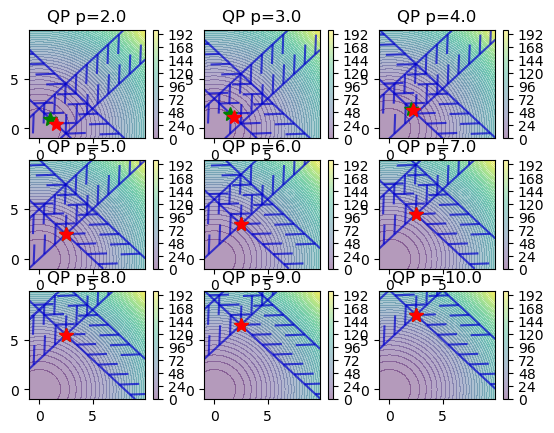

Solution for 2000 problems via solver obtained in 12.5565 seconds
Solver mean constraints violation 0.0000
Solver mean objective value 25.7861

Neuromancer mean constraints violation no DR 0.0000
Neuromancer mean objective value no DR 28.4382
MSE primal optimizers no DR: 0.07781453865668587
mean objective value discrepancy np DR: 10.28 % 

Solution for 2000 problems via Neuromancer obtained in 0.0472 seconds
Neuromancer mean constraints violation 0.0001
Neuromancer mean objective value 25.9413
Solution speedup factor 265.8994
MSE primal optimizers: 0.15450823896982838
mean objective value discrepancy: 0.60 %


In [28]:


'''
#######################################
#######################################

Compare to CVXPY Solver

#######################################
########################################
'''


"""
CVXPY benchmarks
"""
# Define the CVXPY problems.

def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                        [-x - y + p1 <= 0,
                        x + y - p1 - 5 <= 0,
                        x - y + p2 - 5 <= 0,
                        -x + y - p2 <= 0])
    return prob, x, y


"""
Plots
"""
# test problem parameters
params = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
x1 = np.arange(-1.0, 10.0, 0.05)
y1 = np.arange(-1.0, 10.0, 0.05)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4)
    ax[row_id, column_id].set_title(f'QP p={p}')

    c1 = xx + yy - p
    c2 = -xx - yy + p + 5
    c3 = -xx + yy - p + 5
    c4 = xx - yy + p
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
    cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
    cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='mediumblue', alpha=0.7)
    plt.setp(cg1.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    plt.setp(cg2.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    plt.setp(cg3.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    plt.setp(cg4.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)

    fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    
    prob, x, y = QP_param(p, p)
    
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                    'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'primal solution x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    #print(f' f: {model_out["test_" + f.key]}')
    #print(f' g1: {model_out["test_" + g1.key]}')
    #print(f' g2: {model_out["test_" + g2.key]}')

    #print(f' g3: {model_out["test_" + g3.key]}')
    #print(f' g4: {model_out["test_" + g4.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
plt.show()
plt.show(block=True)
plt.interactive(False)

"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 5)
    con_3_viol = np.maximum(0, x - y + p2 - 5)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean
    #return [con_1_viol,con_2_viol,con_3_viol,con_4_viol]

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
with torch.no_grad():
    t = time.time()
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
    nm_time = time.time() - t

x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()


x_nm_noDR = model_out['test_x_predicted'][:, [0]].detach().numpy()
y_nm_noDR = model_out['test_x_predicted'][:, [1]].detach().numpy()


# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='ECOS_BB', verbose=False)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t

x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

p1_vec = samples_test['p1'].detach().numpy()
p2_vec = samples_test['p2'].detach().numpy()


# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1_vec, p2_vec)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')




# Evaluate neuromancer solution no DR
nm_con_viol_mean = eval_constraints(x_nm_noDR, y_nm_noDR, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation no DR {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm_noDR, y_nm_noDR)
print(f'Neuromancer mean objective value no DR {nm_obj_mean:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm_noDR)[:,0]
dy = (y_solver - y_nm_noDR)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers no DR:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy np DR: {err_obj:.2f} % \n')



# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')


# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers0
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')




In [24]:
'''
Convergence Evaluation
'''
solver.num_steps = 30
p1 = -1.0
p2 = -1.0
test_p = torch.tensor([p1,p2],dtype=torch.float32)
test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)

prob, x, y = QP_param(p1, p2)
prob.solve(solver='ECOS_BB', verbose=False)
prob.solve()
x_true = x.value
y_true = y.value


test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[3]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:2]

#np.save('Convergence_Data/pqpADMMtrained.npy',x_hist)

In [25]:
x_hist

array([[ 0.32      , -0.37      ],
       [ 0.8623636 , -1.0661368 ],
       [ 0.72442067, -0.89404196],
       [ 0.6085731 , -0.7496643 ],
       [ 0.5113213 , -0.62854844],
       [ 0.42957962, -0.5269749 ],
       [ 0.36235368, -0.44334024],
       [ 0.31150985, -0.37924534],
       [ 0.27574313, -0.33283404],
       [ 0.25343597, -0.3022622 ],
       [ 0.24282932, -0.28522545],
       [ 0.24218905, -0.2795955 ],
       [ 0.24961066, -0.28327864],
       [ 0.26332486, -0.29421395],
       [ 0.28185523, -0.3105762 ],
       [ 0.30358827, -0.3307057 ],
       [ 0.32725573, -0.35311913],
       [ 0.35179496, -0.3765707 ],
       [ 0.376207  , -0.3999784 ],
       [ 0.39973688, -0.4226299 ],
       [ 0.42176497, -0.44373113],
       [ 0.44191265, -0.46292913],
       [ 0.45994294, -0.47990584],
       [ 0.475554  , -0.49446133],
       [ 0.48883057, -0.5065762 ],
       [ 0.4997214 , -0.51629436],
       [ 0.50837314, -0.52371204],
       [ 0.5149083 , -0.52902776],
       [ 0.51962125,